# Compute Surface Normals

In this notebook we will learn how to compute surface normals to be used for training a multitask model. It has been shown that including surface normals in multi task training can improve performance for both segmentation and monocular depth estiation [1].

To compute the normals, we will first create a point cloud from the depth image and then use open3d to estimate the normals


[1] https://arxiv.org/pdf/1905.07553.pdf

In [1]:
import os

import numpy as np
import cv2
import open3d as o3d

import torch 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [17]:
Tx = 0.209313 # baseline meters

# focal lengths (pixels)
fx = 2262.52
fy = 2265.3017905988554

# u, v principle points
u0 = 1096.98
v0 = 513.137

In [3]:
from dataloader import CityScapesDataset

root = "C:/Users/itber/Documents/datasets/cityscapes"

train_dataset = CityScapesDataset(root, transform=None, split='train', label_map='trainId', crop=False)
valid_dataset = CityScapesDataset(root, transform=None, split='val', label_map='trainId', crop=False)
test_dataset = CityScapesDataset(root, transform=None, split='test', label_map='trainId', crop=False)

In [4]:
idx = 100 

sample = train_dataset[idx]
left, mask, depth = sample['left'], sample['mask'], sample['depth']

In [5]:
H, W = mask.shape

In [6]:
left.shape, mask.shape, depth.shape

((1024, 2048, 3), (1024, 2048), (1024, 2048))

In [8]:
rgbd = o3d.geometry.RGBDImage()
rgbd_img = rgbd.create_from_color_and_depth(o3d.geometry.Image(left), 
                                            o3d.geometry.Image(depth.astype(np.float32)),
                                            convert_rgb_to_intensity=False)

In [9]:
rgbd_img

RGBDImage of size 
Color image : 2048x1024, with 3 channels.
Depth image : 2048x1024, with 1 channels.
Use numpy.asarray to access buffer data.

In [10]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(width=W, height=H, fx=fx, fy=fy, cx=u0, cy=v0)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_img, intrinsics)

In [11]:
# o3d.visualization.draw_plotly([pcd])

In [12]:
pcd.estimate_normals()

In [13]:
dir(pcd)

['HalfEdgeTriangleMesh',
 'Image',
 'LineSet',
 'PointCloud',
 'RGBDImage',
 'TetraMesh',
 'TriangleMesh',
 'Type',
 'Unspecified',
 'VoxelGrid',
 '__add__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'cluster_dbscan',
 'colors',
 'compute_convex_hull',
 'compute_mahalanobis_distance',
 'compute_mean_and_covariance',
 'compute_nearest_neighbor_distance',
 'compute_point_cloud_distance',
 'covariances',
 'create_from_depth_image',
 'create_from_rgbd_image',
 'crop',
 'dimension',
 'estimate_covariances',
 'estimate_normals',
 'estimate_point_covariances',
 'farthest_point_down_sample',
 'get_axis_aligned_bounding_box',
 'get_center',
 'get_g

In [15]:
np.asarray(pcd.normals)

array([[ 0.29678621,  0.89000297,  0.34613966],
       [ 0.29678638,  0.89000288,  0.34613973],
       [ 0.29678621,  0.89000297,  0.34613966],
       ...,
       [-0.00972467, -0.9800526 ,  0.19850018],
       [-0.0147294 ,  0.99709889, -0.07467834],
       [ 0.92830418, -0.0885    , -0.36113584]])

In [13]:
o3d.visualization.draw_geometries([pcd])

In [18]:
np.asarray(pcd.normals).shape

(2097152, 3)

In [19]:
np.asarray(pcd.points)

array([[-0.22521225, -0.10521871,  0.46450001],
       [-0.23263635, -0.10878641,  0.48025   ],
       [-0.23738473, -0.11110824,  0.4905    ],
       ...,
       [ 0.0020214 ,  0.00108581,  0.00482422],
       [ 0.00204647,  0.00109812,  0.00487891],
       [ 0.0021208 ,  0.00113681,  0.00505078]])

## Different way using Q matrix

ref: https://stackoverflow.com/questions/27374970/q-matrix-for-the-reprojectimageto3d-function-in-opencv

In [18]:
# instrinsic matrix/camera matrix
K = np.array([
    [fx, 0, u0],
    [0,  fx, v0],
    [0,  0,  1 ]
])

# translation vector
t = np.array([
        [Tx],
        [0.0],
        [0.0]
])

In [19]:
Q = np.array([
    [1, 0, 0, -u0],
    [0, 1, 0, -v0],
    [0, 0, 0, fx],
    [0, 0, -1/Tx, 0]
])

Q = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1=K,
                  cameraMatrix2=K, \
                  distCoeffs1=0, 
                  distCoeffs2=0, \
                  imageSize=left.shape[:2], \
                  R=np.identity(3), 
                  T=t, \
                  R1=None, 
                  R2=None, \
                  P1=None, 
                  P2=None, 
                  Q=Q);

In [22]:
Q.shape

(4, 4)

In [24]:
depth.dtype

dtype('float16')

In [25]:
# project depth values to 3D space
points = cv2.reprojectImageTo3D(depth.astype(np.float32), Q)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


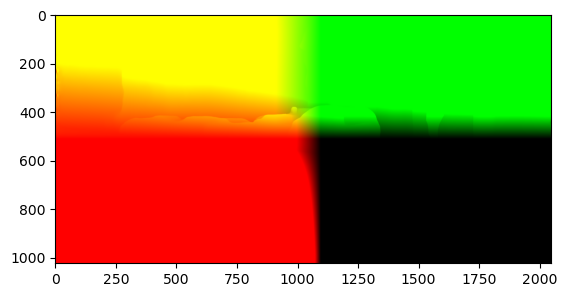

In [28]:
plt.imshow(points)

In [29]:
def get_surface_normal_by_depth(depth, K=None):
    """
    depth: (h, w) of float, the unit of depth is meter
    K: (3, 3) of float, the depth camere's intrinsic
    """
    K = [[1, 0], [0, 1]] if K is None else K
    fx, fy = K[0][0], K[1][1]

    dz_dv, dz_du = np.gradient(depth)  # u, v mean the pixel coordinate in the image
    # u*depth = fx*x + cx --> du/dx = fx / depth
    du_dx = fx / depth  # x is xyz of camera coordinate
    dv_dy = fy / depth

    dz_dx = dz_du * du_dx
    dz_dy = dz_dv * dv_dy
    # cross-product (1,0,dz_dx)X(0,1,dz_dy) = (-dz_dx, -dz_dy, 1)
    normal_cross = np.dstack((-dz_dx, -dz_dy, np.ones_like(depth)))
    # normalize to unit vector
    normal_unit = normal_cross / np.linalg.norm(normal_cross, axis=2, keepdims=True)
    # set default normal to [0, 0, 1]
    normal_unit[~np.isfinite(normal_unit).all(2)] = [0, 0, 1]
    return normal_unit

In [30]:
normals = get_surface_normal_by_depth(depth.astype(np.float32), K=K)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


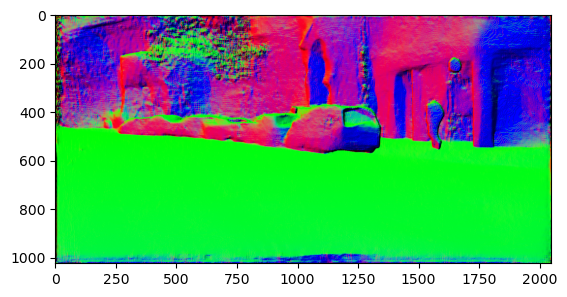

In [31]:
plt.imshow(normals)

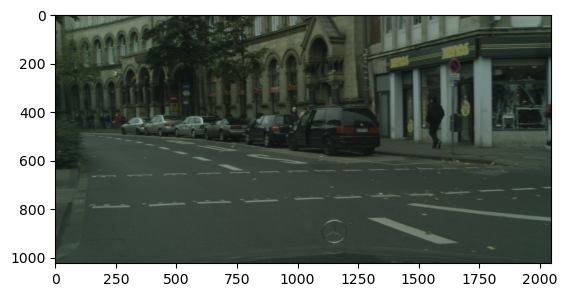

In [32]:
plt.imshow(left)

In [39]:
zy, zx = np.gradient(depth.astype(np.float32))  
# You may also consider using Sobel to get a joint Gaussian smoothing and differentation
# to reduce noise
#zx = cv2.Sobel(d_im, cv2.CV_64F, 1, 0, ksize=5)     
#zy = cv2.Sobel(d_im, cv2.CV_64F, 0, 1, ksize=5)

normal = np.dstack((-zx, -zy, np.ones_like(depth.astype(np.float32))))
n = np.linalg.norm(normal, axis=2)
normal[:, :, 0] /= n
normal[:, :, 1] /= n
normal[:, :, 2] /= n

# offset and rescale values to be in 0-255
# normal += 1
# normal /= 2
# normal *= 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


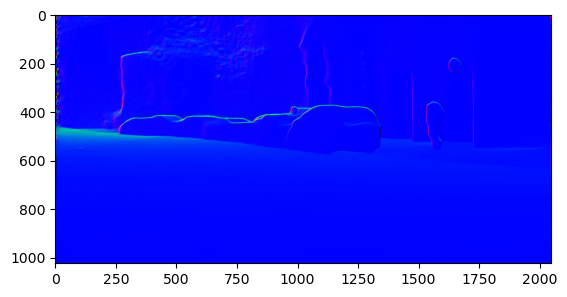

In [41]:
plt.imshow(normal)

Need to project points back to image

sources: 
- https://hedivision.github.io/Pinhole.html
- https://en.wikipedia.org/wiki/Rotation_matrix

In [26]:
# instrinsic matrix/camera matrix
K = np.array([
    [fx, 0, u0],
    [0, fx, v0],
    [0, 0, 0]
])

# translation vector
t = np.array([
        [1.7],
        [0.1],
        [1.22]
])

# rotation matrix
alpha = -0.0195 # yaw
beta = 0.038    # pitch
gamma = 0.0     # roll
R = np.array([
    [np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma) + np.sin(alpha)*np.sin(gamma)],
    [np.cos(beta)*np.sin(gamma), np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma), np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
    [-np.sin(beta), np.sin(alpha)*np.cos(beta), np.cos(alpha)*np.cos(beta)]
])

# Projection Matrix
P = K @ np.vstack(np.hstack((R, t)), np.array([0, 0, 0, 1]))

In [36]:
P

array([[2219.21144864,  -23.05033046, 1181.91839789, 5184.5996    ],
       [ -19.49451353, 2252.09153777,  556.78541702,  852.27914   ],
       [   0.        ,    0.        ,    0.        ,    0.        ]])

In [35]:
np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1]))).shape

(4, 4)

In [31]:
pnt = np.c_[np.array([-0.22521225, -0.10521871,  0.46450001, 1])]
pnt

array([[-0.22521225],
       [-0.10521871],
       [ 0.46450001],
       [ 1.        ]])

In [49]:
P @ np.c_[np.hstack((np.asarray(pcd.points)[10000], 1))]

array([[5220.55249528],
       [ 853.12794735],
       [   0.        ]])

In [46]:
np.c_[np.asarray(pcd.points)[1000]]

array([[-0.00149755],
       [-0.00791406],
       [ 0.0349375 ]])